In [13]:
import numpy as np
from scipy.stats import wasserstein_distance
from scipy import stats
import ot  # pip install POT
import pandas as pd
from scipy.stats import wasserstein_distance, entropy
from scipy.optimize import linprog
import ot
from itertools import combinations
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
def midpoint_from_label(label):
    s = str(label).strip()
    if '+' in s:
        base = int(s.replace('+',''))
        return base + 2.5
    if '-' in s:
        lo, hi = s.split('-')
        return (float(lo) + float(hi)) / 2.0
    try:
        return float(s)
    except:
        raise ValueError(f"Unrecognized age label: {label}")

def get_KL_divergence(dx1, dx2):
    """Get Kullback-Leibler divergence KL(dx1 || dx2). dx1, dx2 must be arrays summing to 1."""
    eps = 1e-12
    dx1_safe = np.clip(dx1, eps, 1.0)
    dx2_safe = np.clip(dx2, eps, 1.0)
    return float(entropy(dx1_safe, dx2_safe))

def get_Jaccard_distance(dx1, dx2):
    """Get Jaccard distance between two dx functions (1 - similarity).
    dx1, dx2 must be non-negative arrays defined on the same support.
    """
    numerator = np.sum(np.minimum(dx1, dx2))
    denominator = np.sum(np.maximum(dx1, dx2))
    if denominator == 0:
        return 0.0
    jaccard_similarity = numerator / denominator
    return float(1.0 - jaccard_similarity)

def midpoint_from_label(label):
    s = str(label).strip()
    if '+' in s:
        base = int(s.replace('+',''))
        return base + 2.5
    if '-' in s:
        lo, hi = s.split('-')
        return (float(lo) + float(hi)) / 2.0
    try:
        return float(s)
    except:
        raise ValueError(f"Unrecognized age label: {label}")

def compute_wasserstein_from_dfs(dfA, dfB, lambda_cause=None, verbose=False):
    """
    Inputs:
      - dfA, dfB: DataFrames with columns ['age','cause','deaths'].
      - lambda_cause: None or scalar (float). If None, default = W_all_scipy * n_causes.
    Returns: dict with W_all_cdf, W_all_scipy, W_joint, lambda_cause_used, and extras.
    """
    # Validate input columns
    for df in (dfA, dfB):
        if not {'age','cause','deaths'}.issubset(df.columns):
            raise ValueError("DataFrames must contain columns: 'age','cause','deaths'")

    # ages union sorted by midpoint
    ages_labels = sorted(set(dfA['age'].unique()).union(dfB['age'].unique()),
                         key=lambda x: midpoint_from_label(x))
    midpoints = np.array([midpoint_from_label(lab) for lab in ages_labels], dtype=float)
    age2idx = {lab:i for i,lab in enumerate(ages_labels)}

    # causes union sorted
    causes = sorted(set(dfA['cause'].unique()).union(dfB['cause'].unique()))
    cause2idx = {c:i for i,c in enumerate(causes)}
    n_age = len(ages_labels); n_cause = len(causes)

    # build joint matrices
    def build_joint(df):
        arr = np.zeros((n_age, n_cause), dtype=float)
        for _, row in df.iterrows():
            i = age2idx[row['age']]
            j = cause2idx[row['cause']]
            arr[i,j] += float(row['deaths'])
        return arr

    dA_joint = build_joint(dfA)
    dB_joint = build_joint(dfB)
    totalA = dA_joint.sum(); totalB = dB_joint.sum()
    if totalA <= 0 or totalB <= 0:
        raise ValueError("Total deaths must be positive in each dataframe")

    # normalize
    dA_joint = dA_joint / totalA
    dB_joint = dB_joint / totalB

    # age marginals
    dA_age = dA_joint.sum(axis=1)
    dB_age = dB_joint.sum(axis=1)

    # all-cause W1 (scipy)
    W_all_scipy = float(wasserstein_distance(midpoints, midpoints, dA_age, dB_age))

    # all-cause via CDF discrete integral
    order = np.argsort(midpoints)
    x_sorted = midpoints[order]
    a_sorted = dA_age[order]; b_sorted = dB_age[order]
    cdfA = np.cumsum(a_sorted); cdfB = np.cumsum(b_sorted)
    widths = np.diff(x_sorted)
    if len(widths) == 0:
        W_all_cdf = 0.0
    else:
        W_all_cdf = float(np.sum(np.abs(cdfA[:-1] - cdfB[:-1]) * widths))

    # sanity
    if not np.isclose(W_all_scipy, W_all_cdf, rtol=1e-8, atol=1e-8) and verbose:
        print("Warning: all-cause CDF and scipy differ by", W_all_scipy - W_all_cdf)

    # default lambda if None: scale by number of causes
    if lambda_cause is None:
        lambda_used = float(W_all_scipy * len(causes))
    else:
        # lambda_cause must be scalar here
        lambda_used = float(lambda_cause)

    # flatten joints
    a_vec = dA_joint.flatten(); b_vec = dB_joint.flatten()
    a_vec = np.clip(a_vec, 0.0, None); b_vec = np.clip(b_vec, 0.0, None)
    if a_vec.sum() == 0 or b_vec.sum() == 0:
        raise ValueError("After clipping, one distribution has zero mass")
    a_vec = a_vec / a_vec.sum(); b_vec = b_vec / b_vec.sum()

    # build coords and cost matrix M
    coords = [(midpoints[i], causes[j]) for i in range(n_age) for j in range(n_cause)]
    N = len(coords)
    M = np.zeros((N, N), dtype=float)
    for i,(xi,ci) in enumerate(coords):
        for j,(xj,cj) in enumerate(coords):
            age_cost = abs(xi - xj)
            cause_cost = lambda_used if (ci != cj) else 0.0
            M[i,j] = age_cost + cause_cost

    # compute joint OT via POT (emd2)
    av = a_vec.copy(); bv = b_vec.copy()
    av = av / av.sum(); bv = bv / bv.sum()
    W_joint = float(ot.emd2(av, bv, M))
    # try to get coupling (optional)
    try:
        gamma = ot.emd(av, bv, M)
    except Exception:
        gamma = None

    return {
        'W_all_cdf': W_all_cdf,
        'W_all_scipy': W_all_scipy,
        'W_joint': W_joint,
        'lambda_cause_used': lambda_used,
        'midpoints': midpoints,
        'causes': causes,
        'gamma': gamma,
        'dA_age': dA_age,
        'dB_age': dB_age,
        'dA_joint': dA_joint,
        'dB_joint': dB_joint
    }

def pairwise_nuts_wasserstein_with_metrics(df_long,
                                           group_keys=('Sex','Year'),
                                           area_key='NUTS',
                                           age_col='age',
                                           cause_col='cause',
                                           deaths_col='deaths',
                                           lambda_cause=None,
                                           verbose=False):
    """
    For each (Sex, Year) compute pairwise Wasserstein between all NUTS areas and
    also compute KL divergence and Jaccard distance on the all-cause age distributions.

    lambda_cause may be:
      - None: the compute_wasserstein_from_dfs will set default = W_all_scipy * n_causes
      - scalar: same lambda for all groups
      - list/tuple/array-like of length >= 2: interpreted as [lambda_female, lambda_male]
          mapping uses case-insensitive matching of Sex values:
            female keywords: {'f','female','woman','w'}
            male   keywords: {'m','male','man'}
          if Sex not recognized, falls back to scalar/default behavior.
    """
    # check columns
    req = set(list(group_keys) + [area_key, age_col, cause_col, deaths_col])
    if not req.issubset(df_long.columns):
        missing = req - set(df_long.columns)
        raise ValueError("Missing columns in input dataframe: " + ", ".join(missing))

    # helper to map sex -> chosen lambda (returns either scalar or None)
    def choose_lambda_for_sex(lambda_cause_param, sex_value):
        if lambda_cause_param is None:
            return None
        # if scalar
        if np.isscalar(lambda_cause_param):
            return float(lambda_cause_param)
        # list-like: pick first for female, second for male
        try:
            seq = list(lambda_cause_param)
            if len(seq) < 2:
                return float(seq[0])  # if only one provided, use it
        except Exception:
            # fallback: try to convert to float
            try:
                return float(lambda_cause_param)
            except Exception:
                return None
        # Normalize sex_value to lowercase short label
        sv = str(sex_value).strip().lower()
        if sv in {'f','female','woman','w'}:
            return float(seq[0])
        if sv in {'m','male','man'}:
            return float(seq[1])
        # if not recognized, fallback to None (so compute_wasserstein will use default)
        return None

    out_rows = []
    grouped = df_long.groupby(list(group_keys))
    for (group_vals, group_df) in grouped:
        # group_vals is tuple when len(group_keys)>1
        # extract sex from group_vals according to position of 'Sex' in group_keys
        if isinstance(group_vals, tuple):
            # build a mapping of group key to value
            grp_map = dict(zip(group_keys, group_vals))
            sex_val = grp_map.get('Sex', grp_map.get('sex', None))
        else:
            # single group key case
            if group_keys[0].lower() == 'sex':
                sex_val = group_vals
            else:
                sex_val = None

        # choose lambda for this sex group
        lambda_for_group = choose_lambda_for_sex(lambda_cause, sex_val)

        # Build mapping NUTS -> subgroup df (age,cause,deaths)
        nuts_groups = {}
        for nuts, sub in group_df.groupby(area_key):
            sub_sel = sub[[age_col, cause_col, deaths_col]].rename(
                columns={age_col:'age', cause_col:'cause', deaths_col:'deaths'}).reset_index(drop=True)
            sub_sel['deaths'] = sub_sel['deaths'].astype(float)
            nuts_groups[nuts] = sub_sel
        nuts_list = sorted(nuts_groups.keys())

        # iterate combinations
        for i, j in combinations(nuts_list, 2):
            subA = nuts_groups[i]
            subB = nuts_groups[j]

            # compute union age support for KL/Jaccard (use age labels)
            ages_union = sorted(set(subA['age'].unique()).union(subB['age'].unique()),
                                key=lambda x: midpoint_from_label(x))

            # build age-marginals (all-cause) on union support
            def build_age_vector(sub, ages_union):
                vec = np.zeros(len(ages_union), dtype=float)
                age2idx = {lab:k for k,lab in enumerate(ages_union)}
                for _, r in sub.iterrows():
                    idxk = age2idx[r['age']]
                    vec[idxk] += float(r['deaths'])
                total = vec.sum()
                if total > 0:
                    vec = vec / total
                return vec

            dxA = build_age_vector(subA, ages_union)
            dxB = build_age_vector(subB, ages_union)

            # KL and Jaccard on age marginals
            try:
                KL_val = get_KL_divergence(dxA, dxB)
            except Exception:
                KL_val = np.nan
            Jaccard_val = get_Jaccard_distance(dxA, dxB)

            # compute Wasserstein distances, passing lambda_for_group (may be None or scalar)
            try:
                res = compute_wasserstein_from_dfs(subA, subB, lambda_cause=lambda_for_group, verbose=verbose)
            except Exception as e:
                if verbose:
                    print(f"Skipping pair {(group_vals, i, j)} due to error: {e}")
                continue

            # assemble output row
            if isinstance(group_vals, tuple):
                row = dict(zip(group_keys, group_vals))
            else:
                row = {group_keys[0]: group_vals}

            row.update({
                'nuts_i': i,
                'nuts_j': j,
                'W_all_scipy': res['W_all_scipy'],
                'W_all_cdf': res['W_all_cdf'],
                'W_joint': res['W_joint'],
                'lambda_used': res['lambda_cause_used'],
                'KL_divergence': KL_val,
                'Jaccard_distance': Jaccard_val
            })
            out_rows.append(row)

    out_df = pd.DataFrame(out_rows)
    cols = list(group_keys) + ['nuts_i','nuts_j','W_all_scipy','W_all_cdf','W_joint','lambda_used','KL_divergence','Jaccard_distance']
    out_df = out_df[cols]
    return out_df


In [15]:
dta = pd.read_csv("regional_life_tables.csv", sep=";", decimal=",")
dta.rename(columns={'Age': 'age', 'Cause': 'cause', 'deaths_rel' : 'deaths'}, inplace=True)
print(dta.head())


   Year  age Sex  NUTS   cause  COD_proportion        mx        qx        ax  \
0  1996    0   f  AT11  Cancer        0.166667  0.000441  0.004396  0.148123   
1  1996   10   f  AT11  Cancer        0.090909  0.000223  0.002228  5.000000   
2  1996   20   f  AT11  Cancer        0.000000  0.000190  0.000947  2.500000   
3  1996   25   f  AT11  Cancer        0.111111  0.000299  0.001495  2.500000   
4  1996   30   f  AT11  Cancer        0.466667  0.000452  0.002259  2.500000   

              lx          dx             Lx            Tx         ex  \
0  100000.000000  439.622920  996254.953720  8.031358e+06  80.313579   
1   99560.377080  221.796413  994494.788736  7.035103e+06  70.661674   
2   99338.580667   94.116971  496457.610908  6.040608e+06  60.808279   
3   99244.463696  148.374586  495851.382014  5.544151e+06  55.863575   
4   99096.089110  223.838050  494920.850423  5.048299e+06  50.943475   

   cause_deaths    deaths  check_sum  
0     73.270487  0.000733          1  
1     20

In [ ]:
#result_df = pairwise_nuts_wasserstein_with_metrics(dta, group_keys=('Sex','Year'))
#result_df.to_csv("results.csv", index=False, sep=";")

In [ ]:
#result_df2 = pairwise_nuts_wasserstein_with_metrics(dta, lambda_cause=[6.59291, 9.83096], group_keys=('Sex','Year'))
#result_df2.to_csv("results2.csv", index=False, sep=";")

In [38]:
result_df = pd.read_csv("results2.csv", sep=";")
result_df.head()


,Sex,Year,nuts_i,nuts_j,W_all_scipy,W_all_cdf,W_joint,lambda_used,KL_divergence,Jaccard_distance
0,f,1996,AT11,AT12,0.256710,0.256710,0.378301,6.59291,0.001533,0.031591
1,f,1996,AT11,AT13,1.036121,1.036121,1.230448,6.59291,0.008474,0.084563
2,f,1996,AT11,AT21,0.698420,0.698420,0.853563,6.59291,0.007845,0.111356
3,f,1996,AT11,AT22,0.306850,0.306850,0.449515,6.59291,0.002199,0.055388
4,f,1996,AT11,AT31,0.396375,0.396375,0.563913,6.59291,0.002511,0.060672


In [39]:
e0_values = pd.read_csv("regional_e0.csv", sep=";", decimal=",")
e0_values.head()

,Year,Sex,NUTS,ex
0,1996,f,AT11,80.313579
1,1999,f,AT11,81.074514
2,2002,f,AT11,81.666558
3,2005,f,AT11,82.239843
4,2008,f,AT11,83.444694


In [40]:
ex_lookup = e0_values.set_index(['Year', 'Sex', 'NUTS'])['ex'].to_dict()

# Function to get ex difference
def get_ex_difference(row):
    key_i = (row['Year'], row['Sex'], row['nuts_i'])
    key_j = (row['Year'], row['Sex'], row['nuts_j'])
    
    ex_i = ex_lookup.get(key_i, np.nan)
    ex_j = ex_lookup.get(key_j, np.nan)
    
    if np.isnan(ex_i) or np.isnan(ex_j):
        return np.nan
    
    return abs(ex_i - ex_j)

# Add the new column
result_df['ex_difference'] = result_df.apply(get_ex_difference, axis=1)

# Check for any missing values
print(f"Number of missing ex_difference values: {result_df['ex_difference'].isna().sum()}")

Number of missing ex_difference values: 0


In [ ]:
#result_df.to_csv("results_final2.csv", index=False, sep=";")

In [41]:
result_df = pd.read_csv("results_final2.csv", sep=";")
result_df.head()

,Sex,Year,nuts_i,nuts_j,W_all_scipy,W_all_cdf,W_joint,lambda_used,KL_divergence,Jaccard_distance,ex_difference
0,f,1996,AT11,AT12,0.256710,0.256710,0.378301,6.59291,0.001533,0.031591,0.149075
1,f,1996,AT11,AT13,1.036121,1.036121,1.230448,6.59291,0.008474,0.084563,0.575383
2,f,1996,AT11,AT21,0.698420,0.698420,0.853563,6.59291,0.007845,0.111356,1.019857
3,f,1996,AT11,AT22,0.306850,0.306850,0.449515,6.59291,0.002199,0.055388,0.345223
4,f,1996,AT11,AT31,0.396375,0.396375,0.563913,6.59291,0.002511,0.060672,0.305293


In [42]:
len(result_df)

138336

In [43]:
cols = ['W_all_scipy', 'W_joint', 'KL_divergence', 'Jaccard_distance', 'ex_difference']
summary_by_year_sex = (
    result_df
    .groupby(['Year', 'Sex'])[cols]
    .agg(['min', 'mean', 'std', 'max'])
    .reset_index()
)

print(summary_by_year_sex)


    Year Sex W_all_scipy                                 W_joint            \
                     min      mean       std       max       min      mean   
0   1996   f    0.081053  1.523867  1.323910  6.125420  0.238874  2.186766   
1   1996   m    0.075136  2.053986  1.611581  8.755807  0.278075  3.008588   
2   1999   f    0.081348  1.481432  1.259482  5.950043  0.175304  2.174005   
3   1999   m    0.110601  2.048187  1.636447  8.877020  0.313320  2.971777   
4   2002   f    0.048368  1.435705  1.225325  5.827764  0.179900  2.109316   
5   2002   m    0.102162  2.042816  1.658792  8.881451  0.362513  2.903212   
6   2005   f    0.050261  1.394507  1.204152  5.537075  0.173302  2.041872   
7   2005   m    0.103358  2.032993  1.726969  9.280609  0.355782  2.882646   
8   2008   f    0.069875  1.281061  1.085426  5.474035  0.185038  1.953110   
9   2008   m    0.093438  2.022839  1.652027  8.790100  0.308705  2.889882   
10  2011   f    0.055591  1.204301  0.963931  4.708462  0.172539

In [50]:
summary_by_year_sex_rounded = summary_by_year_sex.round(3)

summary_by_year_sex_rounded.to_csv(
    "summary_by_year_sex.csv",
    index=False
)


In [34]:
summary_by_sex = (
    result_df
    .groupby(['Sex'])[cols]
    .agg(['min', 'mean', 'std', 'max'])
    .reset_index()
)

print(summary_by_sex)

  Sex W_all_scipy                                 W_joint                      \
              min      mean       std       max       min      mean       std   
0   f    0.048368  1.318582  1.115159  6.125420  0.170330  1.981624  1.595891   
1   m    0.060203  1.966192  1.575033  9.280609  0.256391  2.841892  2.035594   

             KL_divergence  ...                     Jaccard_distance  \
         max           min  ...       std       max              min   
0   7.903947      0.000229  ...  0.045779  0.266545         0.008589   
1  10.911321      0.000257  ...  0.048085  0.341631         0.013247   

                                ex_difference                                 
       mean       std       max           min      mean       std        max  
0  0.157104  0.119801  0.503976      0.000002  2.005424  1.824053   8.481433  
1  0.164049  0.099653  0.509203      0.000031  2.148164  1.968918  10.645139  

[2 rows x 21 columns]


In [51]:
summary_by_sex_rounded = summary_by_sex.round(3)

summary_by_sex_rounded.to_csv(
    "summary_by_sex.csv",
    index=False
)


In [52]:
def plot_quantity_scatter_by_sex(
        df,
        xvar,
        yvar,
        xlabel,
        ylabel,
        title="Scatterplot by Sex",
        line_color="black",
        save_path=None,
        figsize=(14,5)
    ):
    """
    Create side-by-side scatterplots with regression lines for women and men, including Pearson r.
    """

    sns.set_theme(style="ticks")

    sexes = ["f", "m"]

    fig, axes = plt.subplots(1, 2, figsize=figsize, sharex=True, sharey=True)

    for ax, sex in zip(axes, sexes):
        # Subset
        df_sub = df[df["Sex"] == sex].copy()

        # Ensure numeric
        df_sub[xvar] = pd.to_numeric(df_sub[xvar], errors="coerce")
        df_sub[yvar] = pd.to_numeric(df_sub[yvar], errors="coerce")

        # Drop missing
        df_sub = df_sub.dropna(subset=[xvar, yvar])
        if df_sub.shape[0] < 2:
            ax.set_title(f"{sex}: Not enough data")
            continue

        # Scatter + regression line
        sns.regplot(
            data=df_sub,
            x=xvar,
            y=yvar,
            ax=ax,
            line_kws={"color": line_color},
            scatter_kws={"s": 50, "alpha": 0.7, 'edgecolor':'white'},
        )

        # Labels
        if sex == "f":
            ax.set_title("Women")
        if sex == "m":
            ax.set_title("Men")
        
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

        # Pearson correlation
        x = df_sub[xvar].to_numpy()
        y = df_sub[yvar].to_numpy()
        r, p = stats.pearsonr(x, y)

        # Annotate
        ax.text(
            0.05, 0.95,
            f"Pearson r = {r:.2f}",
            transform=ax.transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.7)
        )

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()
    plt.close()

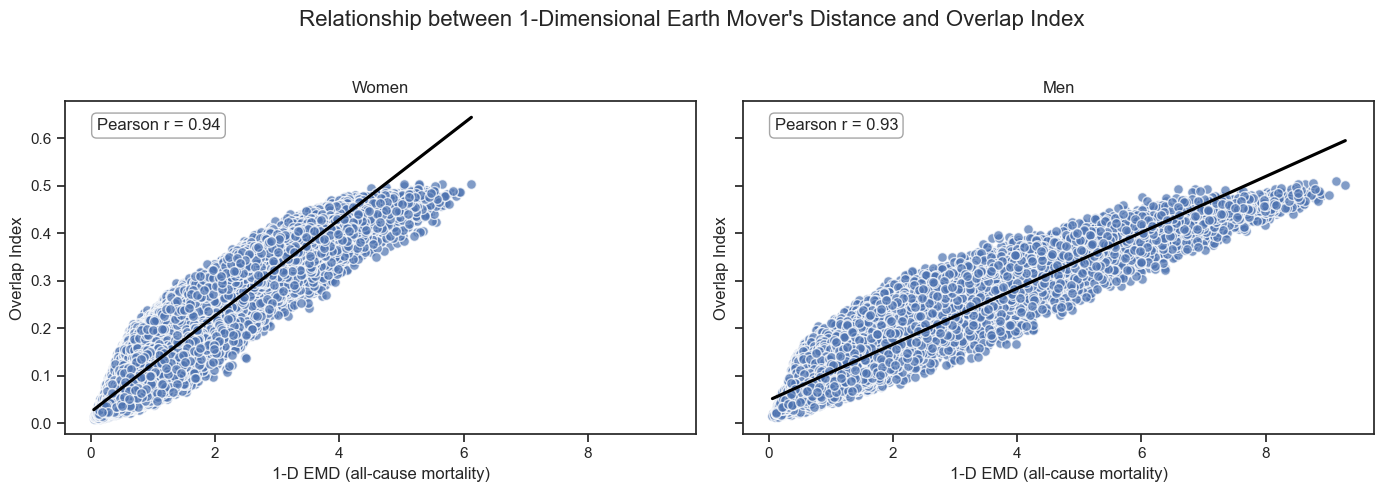

In [71]:
plot_quantity_scatter_by_sex(df = result_df, xvar="W_all_scipy", yvar="Jaccard_distance", xlabel="1-D EMD (all-cause mortality)", ylabel="Overlap Index",
                      title="Relationship between 1-Dimensional Earth Mover's Distance and Overlap Index", save_path="scatter_wasserstein_1D_EMD_Jaccard.png")

In [60]:
sns.set_theme(style="ticks")

def plot_by_year_panels(df,
                        quantity1,
                        quantity2,
                        xlabel,
                        ylabel,
                        sex,
                        years,
                        year_col='Year',
                        sex_col='Sex',
                        figsize=(12, 8),
                        point_kws=None,
                        add_regression=False,
                        out_fname=None,
                        show=True):
    """
    Make a multi-panel scatter plot of quantity2 vs quantity1, one panel per year.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe containing at least columns: year_col, sex_col, quantity1, quantity2.
    quantity1 : str
        Column name for x-axis.
    quantity2 : str
        Column name for y-axis.
    sex : str
        Value in sex_col to filter (e.g., 'm' or 'f').
    years : list-like
        Sequence of year values (exact values appearing in df[year_col]) to plot as panels.
    year_col : str
        Column name for years (default 'Year').
    sex_col : str
        Column name for sex (default 'Sex').
    figsize : tuple
        Figure size (width, height).
    point_kws : dict
        Extra keyword args passed to seaborn.scatterplot for style (e.g., {'s':20, 'alpha':0.7}).
    add_regression : bool
        If True, draw a linear regression line in each panel (uses seaborn.regplot).
    out_fname : str or None
        If provided, save the figure to this filename (PNG/PDF/JPG).
    show : bool
        If True call plt.show() (useful in notebooks). If False, do not show (useful in scripts).
    
    Returns
    -------
    g, fig
        The seaborn.FacetGrid (g) and matplotlib Figure (fig).
    """
    if point_kws is None:
        point_kws = {'s': 50, 'alpha': 0.7, 'edgecolor':'white'}
    years = list(years)
    # Filter by sex
    df_sel = df[df[sex_col] == sex].copy()
    if df_sel.shape[0] == 0:
        raise ValueError(f"No rows for sex == {sex!r}")
    # Ensure quantities are numeric
    df_sel[quantity1] = pd.to_numeric(df_sel[quantity1], errors='coerce')
    df_sel[quantity2] = pd.to_numeric(df_sel[quantity2], errors='coerce')
    # Keep only chosen years (if some are missing we'll still create empty panels)
    df_sel = df_sel[df_sel[year_col].isin(years)].copy()
    if df_sel.shape[0] == 0:
        raise ValueError("No data for chosen years after filtering by sex.")
    # Prepare FacetGrid
    # Use col_wrap=4 so up to 4 panels in a row; if less than 4 years, it will adapt.
    col_wrap = 2
    ncols = min(len(years), col_wrap)
    height = max(figsize[1] / (len(years) // col_wrap + 1), 3)  # heuristic for panel height
    g = sns.FacetGrid(df_sel, col=year_col, col_order=years, col_wrap=col_wrap,
                      height=figsize[1] / (len(years) // col_wrap + 1), aspect=figsize[0]/figsize[1] * (ncols))
    # Map scatterplot
    def _scatter(data, color, **kws):
        sns.scatterplot(data=data, x=quantity1, y=quantity2, color=color, **point_kws)
    g.map_dataframe(_scatter)
    # Optionally add regression lines per panel
    if add_regression:
        def _reg(data, color, **kws):
            # only plot if at least 2 points and not constant
            x = pd.to_numeric(data[quantity1], errors='coerce').dropna().to_numpy()
            y = pd.to_numeric(data[quantity2], errors='coerce').dropna().to_numpy()
            if x.size >= 2 and y.size >= 2 and not (np.all(x == x[0]) or np.all(y == y[0])):
                sns.regplot(data=data, x=quantity1, y=quantity2, scatter=False, truncate=False, color="black", ci=None)
        g.map_dataframe(_reg)
    # Annotate Pearson r in each panel
    axes = g.axes.flatten()
    # If some requested years not present in data, ensure panels still exist
    for ax, yr in zip(axes, years):
        subset = df_sel[df_sel[year_col] == yr]
        # drop NA
        x = pd.to_numeric(subset[quantity1], errors='coerce').dropna().to_numpy()
        y = pd.to_numeric(subset[quantity2], errors='coerce').dropna().to_numpy()
        if x.size < 2 or y.size < 2 or np.all(x == x[0]) or np.all(y == y[0]):
            r_text = "r = n/a"
        else:
            try:
                r, p = stats.pearsonr(x, y)
                r_text = f"r = {r:.2f}"
            except Exception:
                r_text = "r = n/a"
        # place annotation in axes coordinates (top-left)
        ax.text(0.05, 0.95, r_text, transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="gray", alpha=0.6), fontsize=9)
        # set labels and title for each panel
        ax.set_title(str(yr))
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
    # Overall title
    fig = g.fig
    if sex == "f":
        sex_label = "Women"
    else:
        sex_label = "Men"
    fig.suptitle(f"Relationship between 1-Dimensional Earth Mover's Distance and \n 2-Dimensional Earth Mover's Distance over time, {sex_label}", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    # Save or show
    if out_fname is not None:
        fig.savefig(out_fname, dpi=300, bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close(fig)
    return g, fig


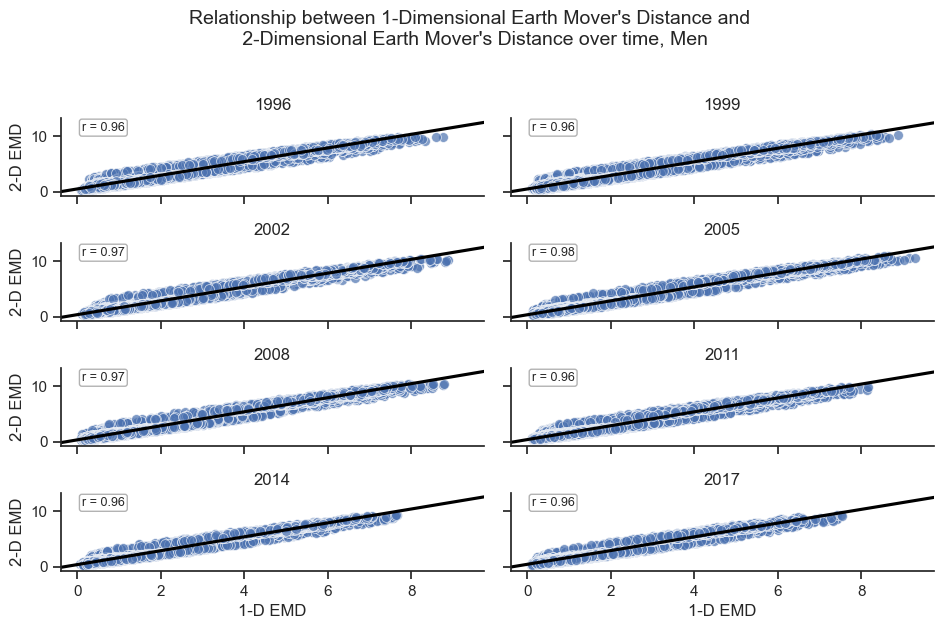

In [62]:
# Four example years (must match values in df['Year'])
years_to_plot = [1990, 2000, 2010, 2020]

g, fig = plot_by_year_panels(result_df,
                             quantity1="W_all_scipy",
                             quantity2="W_joint",
                             xlabel="1-D EMD",
                             ylabel= "2-D EMD",
                             sex='m',
                             years=result_df["Year"].unique(),
                             add_regression=True,
                             out_fname="1D_EMD_vs_2D_EMD_Men.png")


In [39]:
result_df["Year"].unique()

array([1996, 1999, 2002, 2005, 2008, 2011, 2014, 2017])

In [63]:
def find_top_mismatches(df,
                        x_col='W_all_scipy',
                        y_col='W_joint',
                        group_cols=None,
                        top_n=25,
                        min_obs=10,
                        filter_var="ratio_y_over_x",
                        require_positive=True,
                        robust=False):
    """
    Find the top cases where two measures do not correspond.

    Method:
      - Fit a linear model y = slope * x + intercept (ordinary least squares).
      - Compute residuals r = y - (slope*x + intercept).
      - Standardize residuals by their sample std: r_std = r / std(r).
      - Rank by |r_std| and return the top_n rows (largest deviations).

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe containing rows to compare. Expected to contain x_col and y_col.
    x_col : str
        Column name for the predictor (default 'W_all_scipy').
    y_col : str
        Column name for the response (default 'W_joint').
    group_cols : list or None
        List of identifier columns to keep in the output (e.g. ['Sex','Year','nuts_i','nuts_j']).
        If None the function will try to keep any of these that exist: ['Sex','Year','NUTS','nuts_i','nuts_j'].
    top_n : int
        Number of top mismatches to return (default 25).
    min_obs : int
        Minimum number of non-missing observations required to fit the regression; if fewer, function raises.
    require_positive : bool
        If True, filter out rows where both x and y are <= 0 before analysis (useful for probability measures).
    robust : bool
        If True, fit a Theil-Sen robust slope using scipy.stats.theilslopes; otherwise ordinary least squares.

    Returns
    -------
    pandas.DataFrame
        DataFrame containing the top_n mismatches, with columns:
        (group_cols...), x_col, y_col, slope, intercept, y_hat, resid, resid_std,
        abs_diff, rel_diff, ratio_y_over_x
        Sorted descending by |resid_std|.
    """
    df_work = df.copy()

    # Ensure group_cols default
    if group_cols is None:
        preferred = ['Sex','Year','NUTS','nuts_i','nuts_j']
        group_cols = [c for c in preferred if c in df_work.columns]

    # Keep only rows with numeric x and y
    df_work[x_col] = pd.to_numeric(df_work[x_col], errors='coerce')
    df_work[y_col] = pd.to_numeric(df_work[y_col], errors='coerce')

    # Optionally require positive mass/probability entries
    if require_positive:
        df_work = df_work[(df_work[x_col] > 0) | (df_work[y_col] > 0)]

    # Drop NA
    df_work = df_work.dropna(subset=[x_col, y_col]).reset_index(drop=True)

    if df_work.shape[0] < min_obs:
        raise ValueError(f"Not enough observations ({df_work.shape[0]}) to fit regression (min_obs={min_obs}).")

    x = df_work[x_col].to_numpy(dtype=float)
    y = df_work[y_col].to_numpy(dtype=float)

    # Fit slope/intercept
    if robust:
        # Theil-Sen robust slope + intercept
        slope, intercept, lo_slope, hi_slope = stats.theilslopes(y, x, 0.90)
    else:
        # ordinary least squares
        slope, intercept, r_val, p_val, std_err = stats.linregress(x, y)

    # Predicted and residuals
    y_hat = slope * x + intercept
    resid = y - y_hat
    resid_std = resid / (np.std(resid, ddof=1) if np.std(resid, ddof=1) > 0 else 1.0)

    # Additional diagnostics
    abs_diff = np.abs(y - x)
    rel_diff = abs_diff / (np.abs(x) + np.abs(y) + 1e-12)  # symmetric relative difference
    ratio = np.where(np.abs(x) > 1e-12, y / x, np.nan)

    # Assemble results
    out = df_work.loc[:, group_cols].copy() if len(group_cols) > 0 else pd.DataFrame(index=df_work.index)
    out = out.reset_index(drop=True)
    out = pd.concat([out,
                     df_work[[x_col, y_col]].reset_index(drop=True)],
                    axis=1)

    out['slope'] = float(slope)
    out['intercept'] = float(intercept)
    out['y_hat'] = y_hat
    out['resid'] = resid
    out['resid_std'] = resid_std
    out['abs_diff'] = abs_diff
    out['rel_diff'] = rel_diff
    out['ratio_y_over_x'] = ratio
    out['abs_resid_std'] = np.abs(resid_std)

    # Sort by standardized residuals desc and return top_n
    out_sorted = out.sort_values(filter_var, ascending=False).reset_index(drop=True)
    return out_sorted.head(top_n)


In [64]:
# Example: find top 25 pairs where W_all_scipy and W_joint disagree most
top25 = find_top_mismatches(result_df,
                            x_col='W_all_scipy',
                            y_col='W_joint',
                            group_cols=['Sex','Year','nuts_i','nuts_j'],
                            top_n=25,
                            min_obs=20,
                            filter_var= "resid",
                            require_positive=True,
                            robust=False)

display(top25)


,Sex,Year,nuts_i,nuts_j,W_all_scipy,W_joint,slope,intercept,y_hat,resid,resid_std,abs_diff,rel_diff,ratio_y_over_x,abs_resid_std
0,m,2008,FRE12,SK022,1.395839,4.139386,1.2912,0.291108,2.093415,2.045971,4.084728,2.743547,0.495652,2.965519,4.084728
1,m,1996,CZ06,FRE12,0.792175,3.342754,1.2912,0.291108,1.313964,2.028790,4.050427,2.550579,0.616838,4.219718,4.050427
2,m,2002,CZ06,FRE11,0.795936,3.338033,1.2912,0.291108,1.318821,2.019213,4.031306,2.542097,0.614929,4.193846,4.031306
3,m,1999,CZ06,FRE11,0.700949,3.190393,1.2912,0.291108,1.196173,1.994220,3.981408,2.489444,0.639739,4.551534,3.981408
4,m,2002,FRE12,SK022,1.201243,3.831984,1.2912,0.291108,1.842153,1.989831,3.972646,2.630741,0.522675,3.190016,3.972646
5,m,1996,CZ07,FRE12,0.812818,3.329373,1.2912,0.291108,1.340619,1.988754,3.970497,2.516555,0.607542,4.096086,3.970497
6,m,1996,CZ02,FRE12,1.134103,3.740842,1.2912,0.291108,1.755462,1.985380,3.963760,2.606739,0.534722,3.298503,3.963760
7,m,2005,FRE12,SK022,1.581197,4.310367,1.2912,0.291108,2.332750,1.977617,3.948262,2.729170,0.463234,2.726015,3.948262
8,m,2008,CZ07,FRE12,0.765199,3.243345,1.2912,0.291108,1.279132,1.964212,3.921499,2.478146,0.618216,4.238565,3.921499
9,m,2002,CZ06,FRE12,1.166235,3.758114,1.2912,0.291108,1.796950,1.961164,3.915413,2.591879,0.526340,3.222434,3.915413


In [66]:
cols_to_keep = ["Sex", "Year", "nuts_i", "nuts_j", "W_all_scipy", "W_joint", "resid", "abs_diff", "ratio_y_over_x"]
top_25_rounded = top25[cols_to_keep].round(3)
top_25_rounded.to_csv("top25.csv", index=False)

In [67]:
dta_select = dta[(dta["NUTS"].isin(["FRE12", "SK022"])) & (dta["Sex"] == "m") & (dta["Year"] == 2008)]

In [68]:
e0_values = pd.read_csv("regional_e0.csv", sep=";", decimal=",")
e0_values.head()

,Year,Sex,NUTS,ex
0,1996,f,AT11,80.313579
1,1999,f,AT11,81.074514
2,2002,f,AT11,81.666558
3,2005,f,AT11,82.239843
4,2008,f,AT11,83.444694


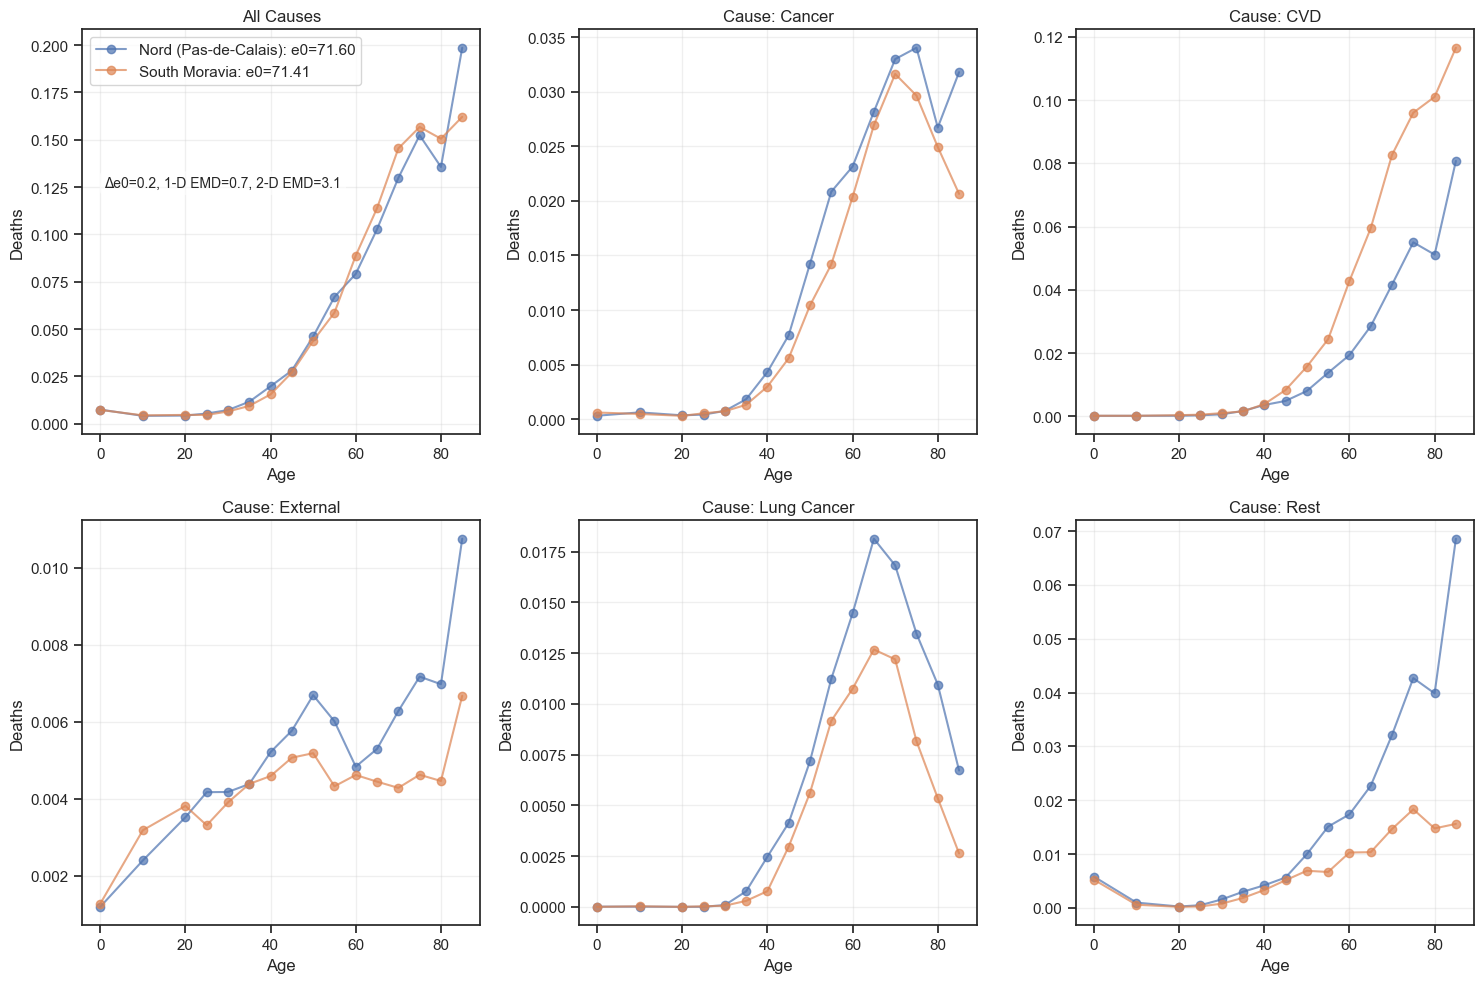

In [69]:
# Filter data for the two NUTS regions
dta_filtered = dta[(dta["NUTS"].isin(["FRE11", "CZ06"])) & (dta["Sex"] == "m") & (dta["Year"] == 1996)]
dta_e0 = e0_values[(e0_values["NUTS"].isin(["FRE11", "CZ06"])) & (e0_values["Sex"] == "m") & (e0_values["Year"] == 1996)]

# Filter result_df for the two regions
result_filtered = result_df[(result_df["nuts_i"] == "CZ06") & 
                            (result_df["nuts_j"] == "FRE11") & 
                            (result_df["Sex"] == "m") & 
                            (result_df["Year"] == 1996)]

# Create a dictionary to store e0 values for each NUTS region
e0_dict = {}
for nuts in ["FRE11", "CZ06"]:
    e0_value = dta_e0[dta_e0["NUTS"] == nuts]["ex"].values[0]
    e0_dict[nuts] = e0_value

# Calculate e0 difference
e0_diff = abs(e0_dict["FRE11"] - e0_dict["CZ06"])

# Get W1 distances
W_all = result_filtered["W_all_scipy"].values[0]
W_joint = result_filtered["W_joint"].values[0]

# Get unique causes
causes = dta_filtered["cause"].unique()

# Create figure with subplots (2x3 grid for all-cause + 4 causes)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()  # Flatten to make indexing easier

# First panel: All-cause deaths (aggregated)
ax = axes[0]
all_cause_data = dta_filtered.groupby(["NUTS", "age"])["deaths"].sum().reset_index()

for nuts in ["FRE11", "CZ06"]:
    if nuts =="FRE11":
        nuts_name = "Nord (Pas-de-Calais)"
    if nuts == "CZ06":
        nuts_name = "South Moravia"
    nuts_data = all_cause_data[all_cause_data["NUTS"] == nuts]
    ax.plot(nuts_data["age"], nuts_data["deaths"], marker='o', 
            label=f'{nuts_name}: e0={e0_dict[nuts]:.2f}', alpha=0.7)

# Add text with the metrics
text_str = f'Δe0={e0_diff:.1f}, 1-D EMD={W_all:.1f}, 2-D EMD={W_joint:.1f}'
ax.text(1, 0.125, text_str, fontsize=10, bbox=dict(boxstyle="round" , facecolor='white', alpha=0.5))

ax.set_xlabel('Age')
ax.set_ylabel('Deaths')
ax.set_title('All Causes')
ax.legend()
ax.grid(True, alpha=0.3)

# Remaining panels: Cause-specific deaths
for i, cause in enumerate(causes):
    ax = axes[i + 1]  # Start from second panel
    
    # Get data for this cause
    cause_data = dta_filtered[dta_filtered["cause"] == cause]
    
    # Plot for each NUTS region
    for nuts in ["FRE11", "CZ06"]:
        nuts_data = cause_data[cause_data["NUTS"] == nuts]
        ax.plot(nuts_data["age"], nuts_data["deaths"], marker='o', 
                label=f'{nuts}: e0={e0_dict[nuts]:.2f}', alpha=0.7)
    
    ax.set_xlabel('Age')
    ax.set_ylabel('Deaths')
    if cause == "LungC":
        ax.set_title(f'Cause: Lung Cancer')
    else: ax.set_title(f'Cause: {cause}')
    
    #ax.legend()
    ax.grid(True, alpha=0.3)

# Hide the last panel if there are only 4 causes (leaving 6th panel empty)
if len(causes) < 5:
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig('deaths_by_cause.png', dpi=300, bbox_inches='tight')
plt.show()

In [91]:
result_test = pairwise_nuts_wasserstein_with_metrics(dta_filtered , lambda_cause=[6.59291, 9.83096], group_keys=('Sex','Year'))

In [ ]:
results = []

# Loop over lambda values from 0 to 100
for lam2 in range(101):  # 0,1,...,100
    # Call the function with lambda_cause=[fixed, variable]
    df_result = pairwise_nuts_wasserstein_with_metrics(
        dta_filtered,
        lambda_cause=[6.59291, lam2],
        group_keys=('Sex', 'Year')
    )
    # Append to the list
    results.append(df_result)

# Combine all results into a single DataFrame
final_df = pd.concat(results, ignore_index=True)

(101, 10)


In [94]:
final_df.head()

,Sex,Year,nuts_i,nuts_j,W_all_scipy,W_all_cdf,W_joint,lambda_used,KL_divergence,Jaccard_distance
0,m,1996,CZ06,FRE11,0.690011,0.690011,0.690011,0.0,0.007918,0.106403
1,m,1996,CZ06,FRE11,0.690011,0.690011,0.935990,1.0,0.007918,0.106403
2,m,1996,CZ06,FRE11,0.690011,0.690011,1.181969,2.0,0.007918,0.106403
3,m,1996,CZ06,FRE11,0.690011,0.690011,1.427948,3.0,0.007918,0.106403
4,m,1996,CZ06,FRE11,0.690011,0.690011,1.673928,4.0,0.007918,0.106403


In [97]:
min_value, max_value = final_df["W_joint"].min(), final_df["W_joint"].max()
print("Min:", min_value, "Max:", max_value)

Min: 0.6900105749289359 Max: 25.208690354799135


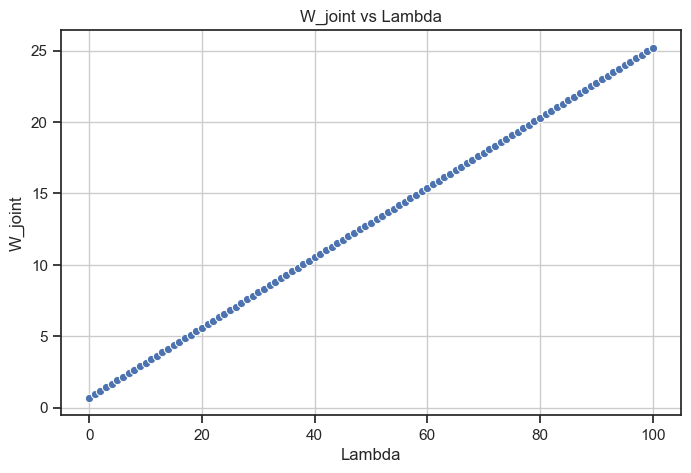

In [95]:
plt.figure(figsize=(8,5))
sns.lineplot(data=final_df, x='lambda_used', y='W_joint', marker='o')
plt.xlabel('Lambda')
plt.ylabel('W_joint')
plt.title('W_joint vs Lambda')
plt.grid(True)
plt.show()

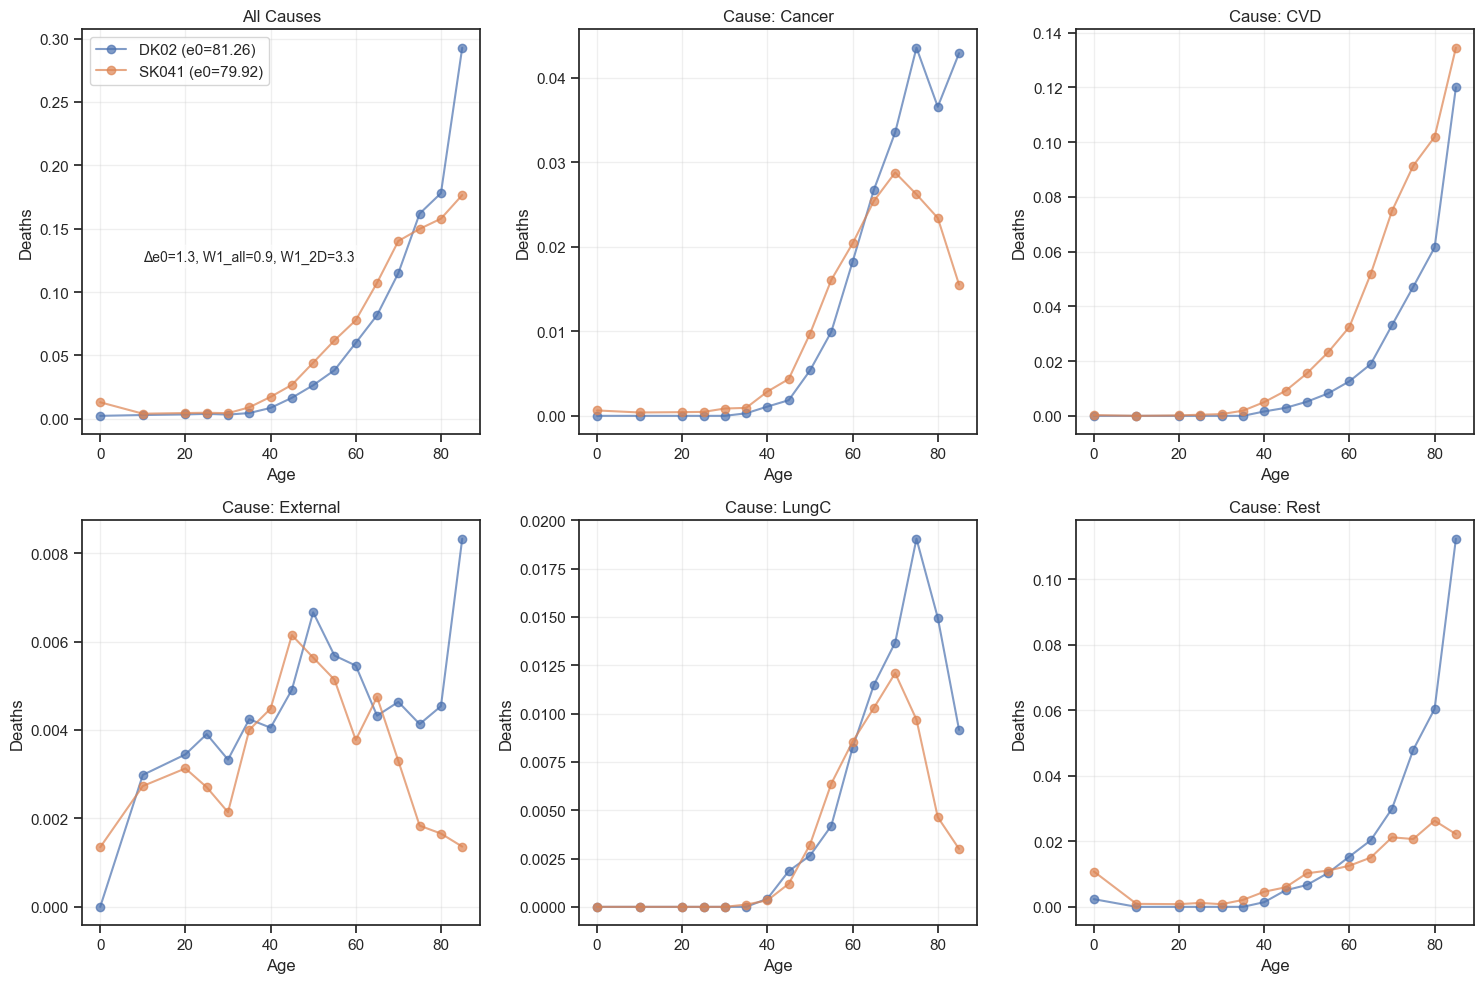

In [ ]:
# Filter data for the two NUTS regions
dta_filtered = dta[(dta["NUTS"].isin(["DK02", "SK041"])) & (dta["Sex"] == "m") & (dta["Year"] == 2008)]
dta_e0 = e0_values[(e0_values["NUTS"].isin(["DK02", "SK041"])) & (e0_values["Sex"] == "f") & (e0_values["Year"] == 2008)]

# Filter result_df for the two regions
result_filtered = result_df[(result_df["nuts_i"] == "DK02") & 
                            (result_df["nuts_j"] == "SK041") & 
                            (result_df["Sex"] == "f") & 
                            (result_df["Year"] == 2008)]

# Create a dictionary to store e0 values for each NUTS region
e0_dict = {}
for nuts in ["DK02", "SK041"]:
    e0_value = dta_e0[dta_e0["NUTS"] == nuts]["ex"].values[0]
    e0_dict[nuts] = e0_value

# Calculate e0 difference
e0_diff = abs(e0_dict["DK02"] - e0_dict["SK041"])

# Get W1 distances
W_all = result_filtered["W_all_scipy"].values[0]
W_joint = result_filtered["W_joint"].values[0]

# Get unique causes
causes = dta_filtered["cause"].unique()

# Create figure with subplots (2x3 grid for all-cause + 4 causes)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()  # Flatten to make indexing easier

# First panel: All-cause deaths (aggregated)
ax = axes[0]
all_cause_data = dta_filtered.groupby(["NUTS", "age"])["deaths"].sum().reset_index()

for nuts in ["DK02", "SK041"]:
    nuts_data = all_cause_data[all_cause_data["NUTS"] == nuts]
    ax.plot(nuts_data["age"], nuts_data["deaths"], marker='o', 
            label=f'{nuts} (e0={e0_dict[nuts]:.2f})', alpha=0.7)

# Add text with the metrics
text_str = f'Δe0={e0_diff:.1f}, W1_all={W_all:.1f}, W1_2D={W_joint:.1f}'
ax.text(10, 0.125, text_str, fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

ax.set_xlabel('Age')
ax.set_ylabel('Deaths')
ax.set_title('All Causes')
ax.legend()
ax.grid(True, alpha=0.3)

# Remaining panels: Cause-specific deaths
for i, cause in enumerate(causes):
    ax = axes[i + 1]  # Start from second panel
    
    # Get data for this cause
    cause_data = dta_filtered[dta_filtered["cause"] == cause]
    
    # Plot for each NUTS region
    for nuts in ["DK02", "SK041"]:
        nuts_data = cause_data[cause_data["NUTS"] == nuts]
        ax.plot(nuts_data["age"], nuts_data["deaths"], marker='o', 
                label=f'{nuts} (e0={e0_dict[nuts]:.2f})', alpha=0.7)
    
    ax.set_xlabel('Age')
    ax.set_ylabel('Deaths')
    ax.set_title(f'Cause: {cause}')
    #ax.legend()
    ax.grid(True, alpha=0.3)

# Hide the last panel if there are only 4 causes (leaving 6th panel empty)
if len(causes) < 5:
    axes[-1].axis('off')

plt.tight_layout()
#plt.savefig('deaths_by_cause.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [57]:
result_df.head()

,Sex,Year,nuts_i,nuts_j,W_all_scipy,W_all_cdf,W_joint,lambda_used,KL_divergence,Jaccard_distance,ex_difference
0,f,1996,AT11,AT12,0.256710,0.256710,0.378301,6.59291,0.001533,0.031591,0.149075
1,f,1996,AT11,AT13,1.036121,1.036121,1.230448,6.59291,0.008474,0.084563,0.575383
2,f,1996,AT11,AT21,0.698420,0.698420,0.853563,6.59291,0.007845,0.111356,1.019857
3,f,1996,AT11,AT22,0.306850,0.306850,0.449515,6.59291,0.002199,0.055388,0.345223
4,f,1996,AT11,AT31,0.396375,0.396375,0.563913,6.59291,0.002511,0.060672,0.305293


In [58]:
result_df.groupby("Sex")["W_all_scipy"].mean()


Sex
f    1.318582
m    1.966192
Name: W_all_scipy, dtype: float64

In [49]:
print(1.318582*5)
print(1.966192*5)

6.59291
9.83096


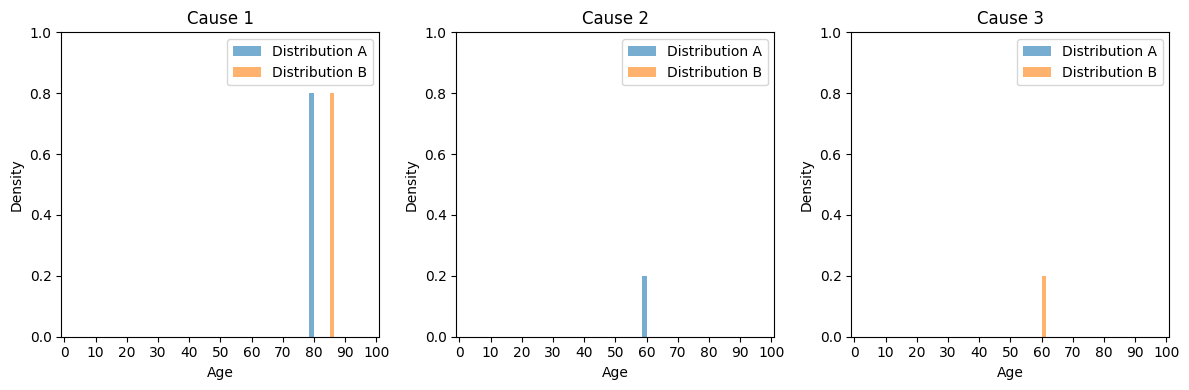

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# --- Figure setup ---
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
ages = np.arange(0, 101)

# Bar width for each bar (smaller than 1 to avoid overlapping)
bar_width = 1.2  # small enough so two bars fit on top of the age
half_width = bar_width / 2

color_A = 'tab:blue'
color_B = 'tab:orange'

# Helper function to plot a pair of distributions, centered exactly on the age
def plot_pair(ax, distA, distB, title, width=1.2):
    half_width = width / 2  # half width for each bar
    ax.bar(ages - half_width/2, distA, width=half_width, alpha=0.6, label='Distribution A', color=color_A)
    ax.bar(ages + half_width/2, distB, width=half_width, alpha=0.6, label='Distribution B', color=color_B)
    ax.set_xlabel('Age')
    ax.set_ylabel('Density')
    ax.set_title(title)
    ax.set_xlim(-1, 101)
    ax.set_ylim(0, 1)
    ax.set_xticks(np.arange(0, 101, 10))
    ax.legend()

# --- Cause 1 ---
distA_c1 = np.zeros_like(ages, dtype=float)
distB_c1 = np.zeros_like(ages, dtype=float)
distA_c1[80] = 0.8
distB_c1[85] = 0.8
plot_pair(axes[0], distA_c1, distB_c1, 'Cause 1', width=3)

# --- Cause 2 ---
distA_c2 = np.zeros_like(ages, dtype=float)
distB_c2 = np.zeros_like(ages, dtype=float)
distA_c2[60] = 0.2
distB_c2[60] = 0
plot_pair(axes[1], distA_c2, distB_c2, 'Cause 2', width=3)

# --- Cause 3 ---
distA_c3 = np.zeros_like(ages, dtype=float)
distB_c3 = np.zeros_like(ages, dtype=float)
distA_c3[60] = 0
distB_c3[60] = 0.2
plot_pair(axes[2], distA_c3, distB_c3, 'Cause 3', width=3)

plt.tight_layout()
plt.savefig('Toyexample_causes_2d.png', dpi=300, bbox_inches='tight')  
plt.show()


In [4]:
import numpy as np
import ot

# ----------------------------
# Define supports
# ----------------------------
ages = np.arange(0, 101)
causes = [1, 2, 3]

# ----------------------------
# Build joint distributions
# Shape: (age, cause)
# ----------------------------
A = np.zeros((len(ages), len(causes)))
B = np.zeros((len(ages), len(causes)))

# Distribution A
A[80, 0] = 0.8   # cause 1
A[60, 1] = 0.2   # cause 2

# Distribution B
B[85, 0] = 0.8   # cause 1
B[60, 2] = 0.2   # cause 3

# Flatten to vectors
a = A.flatten()
b = B.flatten()

# Normalize (safety)
a /= a.sum()
b /= b.sum()

# ----------------------------
# Cost matrix
# ----------------------------
lambda_cause = 10.0

coords = []
for i, age in enumerate(ages):
    for j, cause in enumerate(causes):
        coords.append((age, cause))

N = len(coords)
M = np.zeros((N, N))

for i, (xi, ci) in enumerate(coords):
    for j, (xj, cj) in enumerate(coords):
        age_cost = abs(xi - xj)
        cause_cost = lambda_cause if ci != cj else 0.0
        M[i, j] = age_cost + cause_cost

# ----------------------------
# 2D Wasserstein distance
# ----------------------------
W2D = ot.emd2(a, b, M)

print("2D Wasserstein distance:", W2D)


2D Wasserstein distance: 6.0


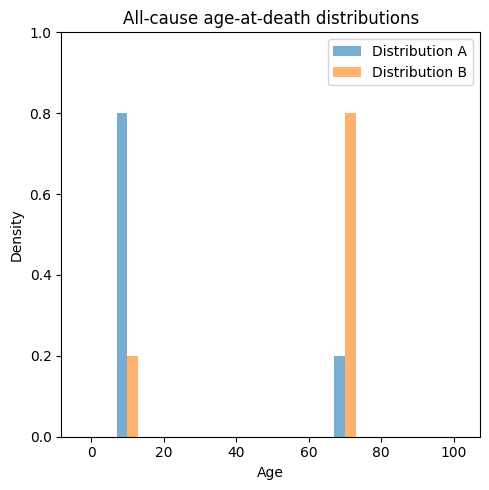

In [3]:
# --- Define distributions ---
ages = np.arange(0, 100)  # ages 0–99

distA = np.zeros_like(ages, dtype=float)
distB = np.zeros_like(ages, dtype=float)

distA[10] = 0.8
distA[70] = 0.2

distB[10] = 0.2
distB[70] = 0.8

# --- Plot ---
plt.figure(figsize=(5, 5))

bar_width = 3   # << much wider bars

plt.bar(ages - bar_width/2, distA, 
        width=bar_width, alpha=0.6, label="Distribution A", color = "tab:blue")

plt.bar(ages + bar_width/2, distB, 
        width=bar_width, alpha=0.6, label="Distribution B", color = "tab:orange")

plt.xlabel("Age")
plt.ylabel("Density")
plt.title("All-cause age-at-death distributions")
plt.legend()
plt.ylim(0, 1)
plt.tight_layout()

# Save the figure in high quality
plt.savefig('Toyexample_causes.png', dpi=300, bbox_inches='tight')  # For vector graphics (best for papers)
# Or use: plt.savefig('figure.png', dpi=300, bbox_inches='tight')  # For raster graphics

plt.show()

In [5]:
import numpy as np
from scipy.stats import wasserstein_distance

# Ages
ages = np.arange(0, 101)

# --- Cause-specific distributions ---
# Distribution A
distA_c1 = np.zeros_like(ages, dtype=float)
distA_c2 = np.zeros_like(ages, dtype=float)
distA_c3 = np.zeros_like(ages, dtype=float)

distA_c1[80] = 0.8
distA_c2[60] = 0.2

# Distribution B
distB_c1 = np.zeros_like(ages, dtype=float)
distB_c2 = np.zeros_like(ages, dtype=float)
distB_c3 = np.zeros_like(ages, dtype=float)

distB_c1[85] = 0.8
distB_c3[60] = 0.2

# --- Aggregate to all-cause ---
distA_all = distA_c1 + distA_c2 + distA_c3
distB_all = distB_c1 + distB_c2 + distB_c3

# Safety check
print(distA_all.sum(), distB_all.sum())


1.0 1.0


In [8]:
distA_all

array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0.8, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ])

In [6]:
W1_scipy = wasserstein_distance(
    ages,
    ages,
    distA_all,
    distB_all
)

print("All-cause W1 (SciPy):", W1_scipy)


All-cause W1 (SciPy): 4.0


In [7]:
# Compute CDFs
cdfA = np.cumsum(distA_all)
cdfB = np.cumsum(distB_all)

# Discrete CDF integral
W1_cdf = np.sum(np.abs(cdfA[:-1] - cdfB[:-1]) * np.diff(ages))

print("All-cause W1 (CDF):", W1_cdf)


All-cause W1 (CDF): 4.0
